In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import time
import os
from sklearn.neighbors import KernelDensity
import networkx as nx
import random

1. create animation (imageio is recommended)
2. most probable for An and Bn
3. check program on graphs from previous list, barabasi, wats strogatz and random. of couse use Monte Carlo approach. it need to hit all other note
try to use Rise (rise pypi) to create presentation

# Task 1

Simulate a random walk of an agent on a square lattice and create gif

In [79]:
'''creates random walk on a square lattice consisting of N steps, then saves it into gif
    IMPORTANT: if simply opening the file doesn't run gif, open it using broswer
'''
def walk(N=int, saved_name = 'task1.gif'):
    walks = 2*np.random.randint(0,2, size=(N,2))-1 #create N vectors where x1 in [-1,1] and x2 in [-1,1]
    for i in range(len(walks[:,1])): #as we want to move on square, not diagonals, in each vector we will change one value to 0
        walks[i,int(np.floor(2*np.random.random()))] = 0
    vals = np.append([[0,0]],np.cumsum(walks, axis=0), axis=0) #with starting point
    
    #now we need limit for plot to have static gif
    llimx = min(vals[:,0])-2
    rlimx = max(vals[:,0])+2
    llimy = min(vals[:,1])-2
    rlimy = max(vals[:,1])+2
    
    #preparing figure
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_xlim(llimx,rlimx)
    ax.set_ylim(llimy,rlimy)
    ax.grid()
    ax.scatter(0,0, edgecolors='green');
    ax.plot([0, vals[0,0]], [0, vals[0,1]], markerfacecolor='blue')
    
    #clearing plot and adding it anew, so that point states where is our plot heading
    for stepy in range(N+1):
        ax.cla()
        ax.set_title('Random walk on a square lattice')
        ax.set_xlim(llimx,rlimx)
        ax.set_ylim(llimy,rlimy)
        ax.grid()
        
        ax.plot(vals[:,0][:stepy+1], vals[:,1][:stepy+1], markerfacecolor='blue');
        ax.scatter(vals[:,0][stepy], vals[:,1][stepy], edgecolors='red');
        
        plt.savefig(f'./task1_{stepy}.png', transparent = False, facecolor = 'white')
        
    #save frames and delete files
    frames = []
    for t in range(N+1):
        frames.append(imageio.imread(f'./task1_{t}.png'))
        os.remove(f'./task1_{t}.png')
        
    #create gif
    imageio.mimsave('./'+saved_name+'.gif', frames, duration=0.5)

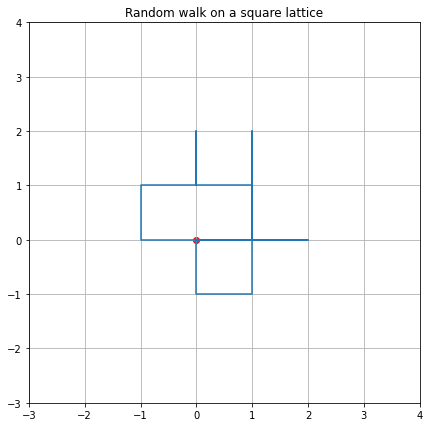

In [80]:
walk(20, 'L');

<img src="L.gif" width="750" align="center">

# Task 2

Simulate Pearson's random walk in the plane. Count how often agent is: x>0 and also x,y>0

In [3]:
def pearson_walk(N=10):
    #creates angles between [0, 2pi] then saves them into columns of X and Y
    angles = np.random.random(N)*2*np.pi
    xs = np.atleast_2d(np.cos(angles)).T
    ys = np.atleast_2d(np.sin(angles)).T
    
    directions = np.append(xs, ys, axis=1) #
    positions = np.cumsum(directions, axis=0)
    #An = sum(positions[0,:]>0)
    
    An = 0
    Bn = 0
    
    for ind in range(N):
        if(positions[ind, 0]>0):
            An+=1
            if(positions[ind, 1]>0):
                Bn+=1
    
    return An/N, Bn/N

In [4]:
def MC_pear(mc=1000):
    Ans = []
    Bns = []
    for i in range(mc):
        an, bn = pearson_walk(1000)
        Ans.append(an)
        Bns.append(bn)
    return Ans, Bns

In [5]:
a,b = MC_pear(10000)

In [6]:
np.mean(a)

0.50074

In [7]:
np.mean(b)

0.2507239

### Density with histogram plot

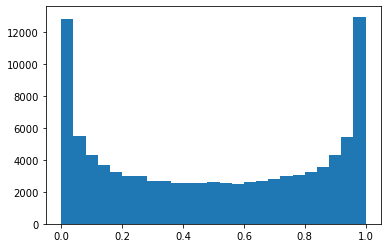

In [180]:
plt.hist(a, bins=25);

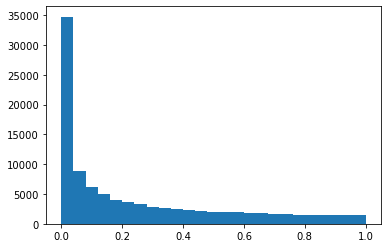

In [181]:
plt.hist(b, bins=25);

### Pdf using Kernel Density

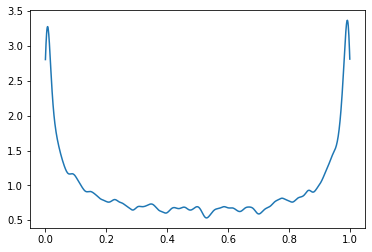

In [38]:
A = np.array(a)[:, np.newaxis]
X_plot = np.linspace(0, 1, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(A)
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))

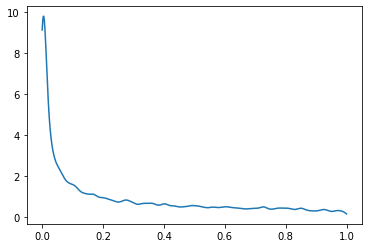

In [39]:
B = np.array(b)[:, np.newaxis]
X_plot = np.linspace(0, 1, 1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(B)
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))

As in histogram plot, we can see that for An, most probable scenarios are that either agent stays all time in right side or rarely visits it. As for Bn, most often it spends not much time on {x>0, y>0}

### Now produce some plots to show how it works

In [198]:
def pearson_plot(N=100):
    #creates angles between [0, 2pi] then saves them into columns of X and Y
    angles = np.random.random(N)*2*np.pi
    xs = np.atleast_2d(np.cos(angles)).T
    ys = np.atleast_2d(np.sin(angles)).T
    
    directions = np.append(xs, ys, axis=1)
    #as it does not contain 0
    directions = np.append([[0,0]], directions, axis=0)
    positions = np.cumsum(directions, axis=0)
    
    plt.scatter(0,0, label='starting plot')
    plt.plot(positions[:,0], positions[:,1])
    plt.legend()

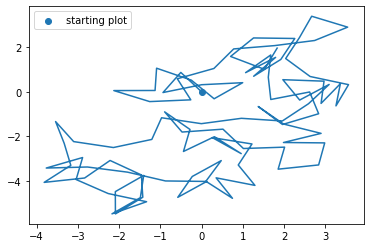

In [199]:
pearson_plot()

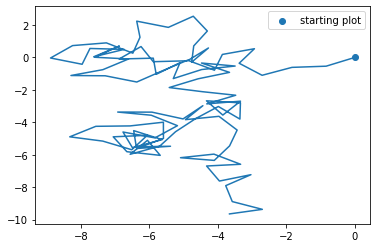

In [200]:
pearson_plot()

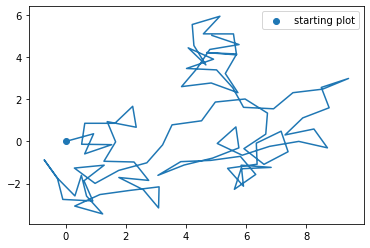

In [201]:
pearson_plot()

# Task 3

Simulate random walk on a graph, using these from previous assingnment. Produce some gif

Let us implement graphs

In [4]:
#There will be Erdos-Renyi model, for graph with fixed number of links L between N nodes 
def Ernyi(N=20, L=20):
    if(L>N*(N-1)/2):
        raise ValueError ("To many edges!") # of course we cannot create matrix of 3 nodes with 4 edges
    G = nx.Graph()
    G.add_nodes_from([i+1 for i in range(N)]) #so we can start from 1
    iterator = 0
    while(iterator<L):
        [i,j] = random.sample(list(G.nodes), 2) #we take two nodes
        if not((i, j) in G.edges):
            G.add_edge(i, j) #we add
        else: #to maintain proper number of links
            iterator = iterator-1 
        iterator = iterator + 1
    
    return G

#N is number of nodes, k is number of closest neighbours and p is probability that we change edge in single step
def Watatz(N=20, k=4, p=1):
    if(k%2==1):
        raise ValueError ("Need even number of closest neighbours!")
    
    #creates starting graph//do not move
    G = nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    
    for i in G.nodes:
        for ki in range(int(k/2)):
            G.add_edges_from([((i+N-1-ki)%N,i), ((i+N+1+ki)%N,i)]) #calculations so N-1 is connected with 0
    
    #changes link for each
    new_G = nx.Graph()
    iterator = 0

    for link in G.edges:
        #relinking
        if(random.random()<p): #if we succeed in relinking
            new_link = link #for now it is as before
            if(random.random()<0.5): #whether relink node 1 or 2 from edge
                #we do not want link that already was in network, not that we have in currently created one
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[0])
                    relink = random.choice(for_choice)
                    new_link = (new_link[0], relink)
                new_G.add_edge(new_link[0], new_link[1])
            else: #same procedure, but we change second end of edge
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[1])
                    relink = random.choice(for_choice)
                    new_link = (relink, new_link[1])
                new_G.add_edge(new_link[0], new_link[1])
        else: #we simply add link that existed in starting network
            new_G.add_edge(link[0], link[1])
        iterator = iterator+1
        
    new_G.add_nodes_from(list(G.nodes)) #in case some node got totally unconnected
    
    return new_G

''' we start with m0 nodes and in each step we add node connected to m<m0 previous nodes until we reach N nodes
    after t steps we should have N=m0+t nodes and E=m0+mt edges
'''
def Barabasi(m0, m, t):
    '''creating, start from 1 to be similar with previous ones
        we want to start with m0 nodes, m0 edges and each link connected,
        so I just start with triangle, then add new linked nodes'''
    
    G = nx.Graph()
    G.add_edges_from([(1,2), (1,3), (2,3)])
    for i in range(3,m0+1): 
        G.add_edge(i, random.choice(list(G.nodes)))
        
    #now we add new nodes, choose m distinct edges coming from new node
    for tau in range(t):
        pi = [nx.degree(G, nody)/(sum([nx.degree(G, n) for n in G.nodes])) for nody in G.nodes] #probability for each node
        choice_list =  np.random.choice(list(G.nodes), m, p=pi, replace=False) #choose randomly with no repetinions
        
        for link in choice_list:
            G.add_edge(link, tau+m0+1)
         #in case we do not link it to any node
      
    return G

In [52]:
G_r = Ernyi(20, 40)
G_w = Watatz(20, 4, 0.5)
G_b = Barabasi(3, 3, 17)

### Creating plot saving function

In [45]:
def walk_graph(G, agent=1, name_movie = 'Movie'):
    #preparing list with visiting times
    nodes = list(G.nodes())
    N = len(nodes)
    walks = [0 for _ in range(N)]#np.zeros(len(nodes))
    walks[nodes.index(agent)]=1 #at the end remember to substract 1
    
    #coloring nodes
    color_map = ['blue' for i in range(N)]
    color_map[nodes.index(agent)] = 'green'
    nx.draw_spectral(G, node_color=color_map)
    plt.savefig(f'./task3_{0}.png', transparent = False, facecolor = 'white')
    
    #value holding currently visited node
    current_visitor = agent
    steps_stepped = 0
    #loop
    while(np.prod(walks)==0):
        steps_stepped+=1
        current_visitor = random.choice(list(G.neighbors(current_visitor))) #we move to neighbour
        
        walks[nodes.index(current_visitor)] = 1 #'this was visited'
        color_map[nodes.index(current_visitor)] = 'red' #here we are
        nx.draw_spectral(G, node_color=color_map) #color for plot
        
        plt.savefig(f'./task3_{steps_stepped}.png', transparent = False, facecolor = 'white')
        
        color_map[nodes.index(current_visitor)] = 'green' #I'd like to have starting node clear whole time
    
    #save frames and delete files
    frames = []
    for t in range(steps_stepped+1):
        frames.append(imageio.imread(f'./task3_{t}.png'))
        os.remove(f'./task3_{t}.png')
        
    #create gif
    imageio.mimsave('./'+name_movie+'.gif', frames, duration=0.25)
    
    return steps_stepped

In [55]:
walk_graph(G_r, 1, 'random');

<img src="random.gif" width="600" align="center">

In [56]:
walk_graph(G_w, 1, 'watatz')

<img src="watatz.gif" width="600" align="center">

In [57]:
walk_graph(G_b, 1, 'barabasi')

<img src="barabasi.gif" width="600" align="center">

### Now, average walk

In [27]:
def statistic_walk_graph(G, agent=1):
    #preparing list with visiting times
    nodes = list(G.nodes())
    N = len(nodes)
    walks = [0 for _ in range(N)]#np.zeros(len(nodes))
    walks[nodes.index(agent)]=1 #at the end remember to substract 1
    
    
    #value holding currently visited node
    current_visitor = agent
    steps_stepped = 0
    #loop
    while(np.prod(walks)==0):
        steps_stepped+=1
        current_visitor = random.choice(list(G.neighbors(current_visitor))) #we move to neighbour
        
        walks[nodes.index(current_visitor)] = 1 #'this was visited'
    
    #save frames and delete files
    
    return steps_stepped

In [5]:
G_r = Ernyi(100, 400)
G_w = Watatz(100, 6, 0.5)
G_b = Barabasi(3, 3, 97)

1348.713


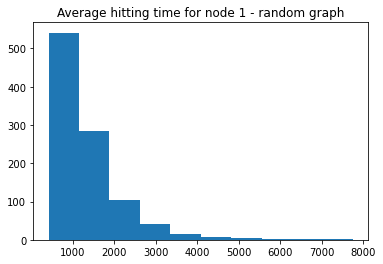

In [43]:
r_walks = [statistic_walk_graph(G_r, 1) for i in range(1000)]
plt.hist(r_walks);
plt.title('Average hitting time for node 1 - random graph');
print(np.mean(r_walks))

798.024


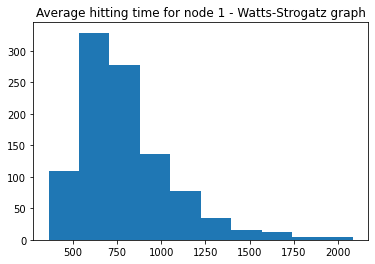

In [42]:
w_walks = [statistic_walk_graph(G_w, 1) for i in range(1000)]
plt.hist(w_walks);
plt.title('Average hitting time for node 1 - Watts-Strogatz graph');
print(np.mean(w_walks))

1000.534


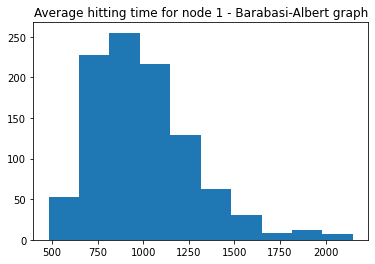

In [41]:
b_walks = [statistic_walk_graph(G_b, 1) for i in range(1000)]
plt.hist(b_walks);
plt.title('Average hitting time for node 1 - Barabasi-Albert graph');
print(np.mean(b_walks))

### Now, does it differ for each node?

In [12]:
r_mean_walks = [np.mean([statistic_walk_graph(G_r, j) for i in range(1000)]) for j in G_r.nodes]

Text(0.5, 1.0, 'Random graph - average hitting times for all nodes')

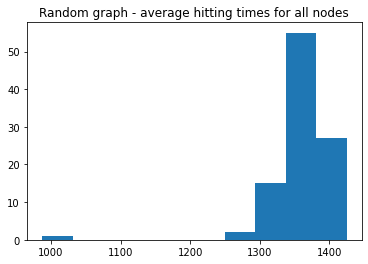

In [38]:
plt.hist(r_mean_walks);
plt.title('Random graph - average hitting times for all nodes');

In [33]:
w_mean_walks = [np.mean([statistic_walk_graph(G_w, j) for i in range(1000)]) for j in G_w.nodes]

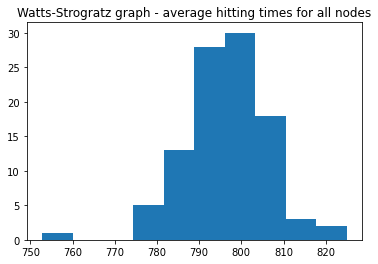

In [39]:
plt.hist(w_mean_walks);
plt.title('Watts-Strogratz graph - average hitting times for all nodes');

In [35]:
b_mean_walks = [np.mean([statistic_walk_graph(G_b, j) for i in range(1000)]) for j in G_b.nodes]

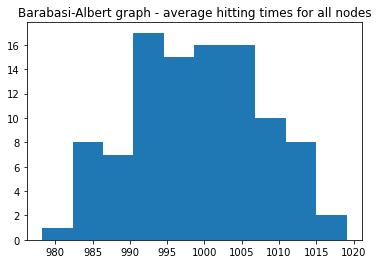

In [40]:
plt.hist(b_mean_walks);
plt.title('Barabasi-Albert graph - average hitting times for all nodes');